In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/kaggle/input/apple-stock-prices/apple_share_price.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


In [3]:
df['OHLC'] = (df['Open'] + df['High'] + df['Low'] + df['Close'])/4
df.head()

,Date,Open,High,Low,Close,Volume,OHLC
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096,157.1800
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273,157.4625
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530,160.1750
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896,159.6950
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321,157.8650


In [4]:
df = df[::-1].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,OHLC
0,3-Jan-11,46.52,47.18,46.41,47.08,111280407,46.7975
1,4-Jan-11,47.49,47.50,46.88,47.33,77337001,47.3000
2,5-Jan-11,47.08,47.76,47.07,47.71,63879193,47.4050
3,6-Jan-11,47.82,47.89,47.56,47.68,75106626,47.7375
4,7-Jan-11,47.71,48.05,47.41,48.02,77982212,47.7975


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

In [6]:
train_size = int(df.shape[0] * 0.7)
df_train= df[:train_size]
df_t = df[train_size:]

val_size = int(df_t.shape[0] * .5)
df_val = df_t[:val_size]
df_test = df_t[val_size:]

In [7]:
df_test.shape

(250, 7)

In [8]:
df_train['OHLC'] = scaler.fit_transform(df_train[['OHLC']])
df_val['OHLC'] = scaler.fit_transform(df_val[['OHLC']])
df_test['OHLC'] = scaler.fit_transform(df_test[['OHLC']])

/tmp/ipykernel_35/1616049625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OHLC'] = scaler.fit_transform(df_train[['OHLC']])
/tmp/ipykernel_35/1616049625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['OHLC'] = scaler.fit_transform(df_val[['OHLC']])
/tmp/ipykernel_35/1616049625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [9]:
df_train.tail()

,Date,Open,High,Low,Close,Volume,OHLC
1159,12-Aug-15,112.53,115.42,109.63,115.24,101685610,0.779665
1160,13-Aug-15,116.04,116.40,114.54,115.15,48535789,0.806285
1161,14-Aug-15,114.32,116.31,114.01,115.96,42929516,0.801910
1162,17-Aug-15,116.04,117.65,115.50,117.16,40884745,0.818351
1163,18-Aug-15,116.43,117.44,116.01,116.50,34560708,0.818437


In [10]:
x_train = df_train['OHLC'].to_numpy()
y_train = df_train['Close'].to_numpy()

x_val = df_val['OHLC'].to_numpy()
y_val = df_val['Close'].to_numpy()

x_test = df_test['OHLC'].to_numpy()
y_test = df_test['Close'].to_numpy()

In [11]:
y_train

array([ 47.08,  47.33,  47.71, ..., 115.96, 117.16, 116.5 ])

In [12]:
import torch
import torch.nn as nn

In [13]:
def get_sequence(x, y, window_size=10):
    X = []
    Y = []
    for i in range(len(x)-window_size):
        X.append(x[i:i+window_size])
        Y.append(y[i+window_size])
    return np.array(X), np.array(Y)

In [14]:
x_train, y_train = get_sequence(x_train,y_train)
x_val, y_val = get_sequence(x_val,y_val)
x_test, y_test = get_sequence(x_test,y_test)

In [15]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [16]:
y_train.shape

torch.Size([1154])

In [17]:
y_train = y_train.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)

y_val = y_val.reshape(-1, 1)
y_val = scaler.fit_transform(y_val)

In [18]:
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [19]:
from torch.utils.data import Dataset, DataLoader

In [20]:
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.features = x.clone().detach().float()
        self.target = y.clone().detach().float()

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [21]:
train_dataset = MyCustomDataset(x_train, y_train)
val_dataset = MyCustomDataset(x_val, y_val)
test_dataset = MyCustomDataset(x_test, y_test)

In [22]:
train_dataset.__getitem__(136)

(tensor([0.1004, 0.1243, 0.1173, 0.1239, 0.1297, 0.1416, 0.1336, 0.1256, 0.1210,
         0.1329]),
 tensor([0.1184]))

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, pin_memory=True)

In [24]:
val_dataset.__getitem__(32)

(tensor([0.6190, 0.6357, 0.6278, 0.5928, 0.6521, 0.6755, 0.6537, 0.6290, 0.6509,
         0.6507]),
 tensor([0.6637]))

In [25]:
class MyLSTM(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.LSTM(input_size=1, hidden_size=128, num_layers=3, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(128,1)

    def forward(self, x):
       out, (h_n, c_n) = self.model(x)
       return self.linear(out[:,-1,:])

In [26]:
model = MyLSTM()

In [27]:
epochs = 30
learning_rate = 0.01
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=3e-4)
loss_fn = nn.MSELoss()

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
train_y_data = []
train_pred_data = []

val_y_data = []
val_pred_data = []

In [42]:
import math
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.unsqueeze(-1).to(device)  # Ensure shape: [batch, seq_len, 1]
        batch_y = batch_y.unsqueeze(1).to(device)   # Ensure shape: [batch, 1]

        optimizer.zero_grad()
        batch_pred = model(batch_x)

        loss = loss_fn(batch_pred, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

        if epoch == epochs-1:
            batch_y = batch_y.squeeze(-1)
            batch_pred = batch_pred.squeeze(-1)

            batch_y_np = batch_y.detach().cpu().numpy().reshape(-1, 1)
            batch_pred_np = batch_pred.detach().cpu().numpy().reshape(-1, 1)

            batch_y_inv = scaler.inverse_transform(batch_y_np).flatten()
            batch_pred_inv = scaler.inverse_transform(batch_pred_np).flatten()

            train_y_data.append(batch_y_inv)
            train_pred_data.append(batch_pred_inv)

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            batch_x = batch_x.unsqueeze(-1).to(device)
            batch_y = batch_y.unsqueeze(1).to(device)

            batch_pred = model(batch_x)

            loss = loss_fn(batch_pred, batch_y)
            val_loss += loss.item() * batch_x.size(0)

            if epoch == epochs-1:
                 batch_y = batch_y.squeeze(-1)
                 batch_pred = batch_pred.squeeze(-1)

                 batch_y_np = batch_y.detach().cpu().numpy().reshape(-1, 1)
                 batch_pred_np = batch_pred.detach().cpu().numpy().reshape(-1, 1)

                 batch_y_inv = scaler.inverse_transform(batch_y_np).flatten()
                 batch_pred_inv = scaler.inverse_transform(batch_pred_np).flatten()

                 val_y_data.append(batch_y_inv)
                 val_pred_data.append(batch_pred_inv)

    # Compute RMSE
    train_rmse = math.sqrt(train_loss / x_train.shape[0])
    val_rmse = math.sqrt(val_loss / x_val.shape[0])

    if epoch == epochs-1:
    
       train_y_data = np.concatenate(train_y_data)
       val_y_data = np.concatenate(val_y_data)
       train_pred_data = np.concatenate(train_pred_data)
       val_pred_data = np.concatenate(val_pred_data)

    print(f'Epoch : {epoch}, Training Loss (RMSE): {train_rmse:.4f}, Validation Loss (RMSE): {val_rmse:.4f}')

    scheduler.step(val_rmse)


Epoch : 0, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 1, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 2, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 3, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 4, Training Loss (RMSE): 0.2716, Validation Loss (RMSE): 0.2610
Epoch : 5, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 6, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 7, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 8, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 9, Training Loss (RMSE): 0.2715, Validation Loss (RMSE): 0.2610
Epoch : 10, Training Loss (RMSE): 0.2714, Validation Loss (RMSE): 0.2610
Epoch : 11, Training Loss (RMSE): 0.2716, Validation Loss (RMSE): 0.2610
Epoch : 12, Training Loss (RMSE): 0.2716, Validation Loss (RMSE): 0.2610
Epoch : 13, Training Loss (RMSE): 0.2715, Validation Loss (RM

In [50]:
model.eval()
test_y_data = []
test_pred_data = []

test_loss = 0

for batch_x, batch_y in test_dataloader:
    batch_x = batch_x.unsqueeze(-1)
    pred_y = model(batch_x)
    loss = loss_fn(pred_y, batch_y)

    batch_y = batch_y.squeeze(-1)
    batch_pred = batch_pred.squeeze(-1)

    batch_y_np = batch_y.detach().cpu().numpy().flatten()
    batch_pred_np = batch_pred.detach().cpu().numpy().flatten()

    # batch_y_inv = scaler.inverse_transform(batch_y_np).flatten()
    # batch_pred_inv = scaler.inverse_transform(batch_pred_np).flatten()

    test_y_data.append(batch_y_np)
    test_pred_data.append(batch_pred_np)
    
    test_loss += loss.item() * batch_y.shape[0]

test_loss = math.sqrt(test_loss/x_test.shape[0])
print(f'Test loss : {test_loss/x_test.shape[0]}')
test_y_data = np.concatenate(test_y_data)
test_pred_data = np.concatenate(test_pred_data)

Test loss : 0.5503856337092634


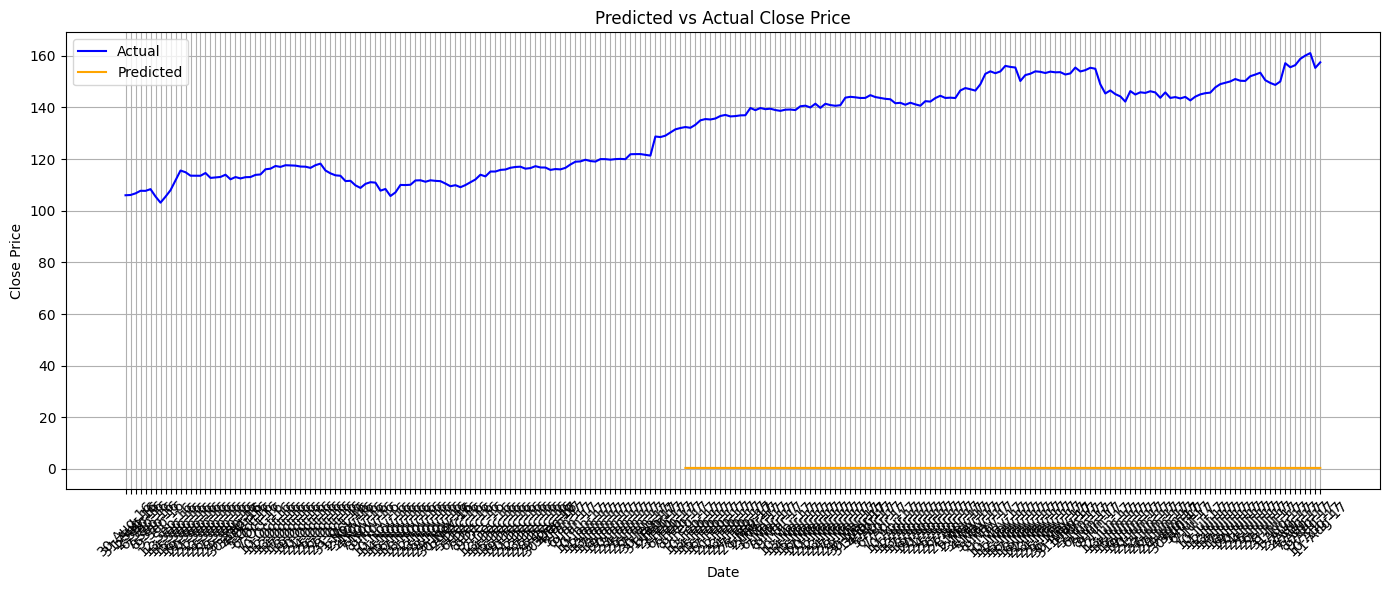

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_test["Date"].values[-len(test_y_data):], test_y_data, label='Actual', color='blue')
plt.plot(df_test["Date"].values[-len(test_pred_data):], test_pred_data, label='Predicted', color='orange')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Close Price')
plt.title('Predicted vs Actual Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
